Cette page cherche à fournir une indication graphique de la representatitivté des corpus de lemmatisation. On se sert pour cela des corpus et d'une datation par oeuvre et par auteur.

In [1]:
# Change directory to the root of These for simpler imports
import os
os.chdir("/home/thibault/dev/these/")

# Imports
import csv
from MyCapytain.common.reference import URN
from collections import namedtuple, Counter
from pandas import DataFrame, Series
from IPython.display import display, HTML
from matplotlib import pyplot 
import seaborn as sns
import pandas

## Récupération des dates de corpora

In [2]:
Date = namedtuple("Date", ["birth", "death"])
dates = {}

# On ouvre le fichier qui contient les dates
with open("data/raw/datation.tsv") as f:
    reader = csv.DictReader(f, delimiter="\t")
    # Pour chacune des URN, on remplit avec le textgroup le dictionnaire data
    for line in reader:
        urn = line["URN"]
        # Si on a une URN et que cette ligne ne doit pas être ignorée
        if urn and line["Ignore"] != "x":
            textgroup = (URN(urn)).upTo(URN.TEXTGROUP)
            if textgroup not in dates:
                try:
                    dates[textgroup] = Date(int(line["Birth"]), int(line["Death"]))
                except Exception:
                    print("Erreur sur la ligne suivante :")
                    print(line)
                    raise

all_dates = list([d for tup in dates.values() for d in tup])
Min_date, Max_date = min(all_dates), max(all_dates)
print(Min_date, Max_date)

-254 735


## Récupérations des informations sur les textes parsés

In [3]:
from helpers.reader.curated import get_graph, get_texts, get_text_length_dict
# Retrieve the metadata graph
graph = get_graph()
# And the list of texts as a dictionary of text: text_length
texts = get_texts()
# And the list of texts as a dictionary of text: text_length
available_wordcount_per_edition = get_text_length_dict(texts)
available_psgcount = Counter()
available_textcount = Counter()
available_wordcount = Counter()

for id_text, count_for_text in available_wordcount_per_edition.items():
    tg = str((URN(id_text)).upTo(URN.TEXTGROUP))
    available_psgcount[tg] += len(count_for_text)
    available_wordcount[tg] += sum(count_for_text)
    available_textcount[tg] += 1


## Ratios de passages / textes

/home/thibault/dev/these/these_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


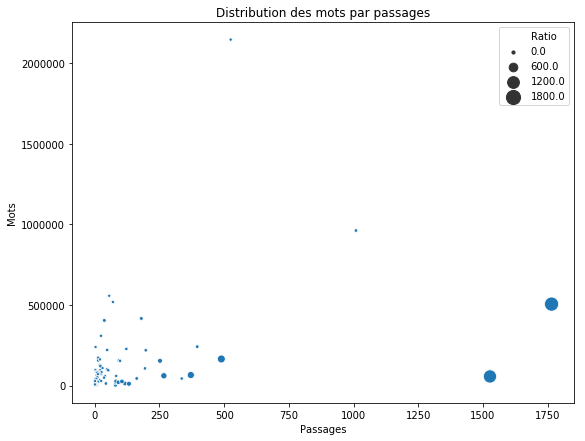

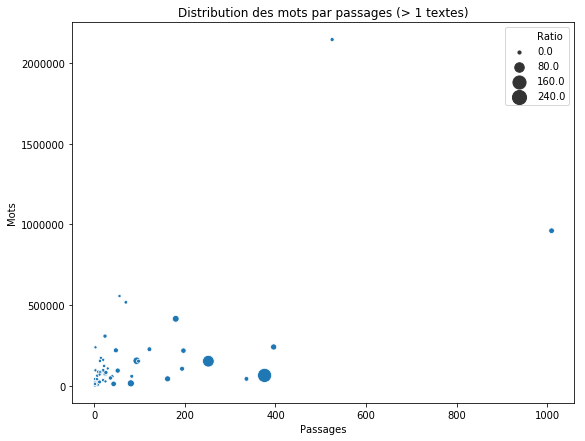

In [4]:
texts = DataFrame([
    {"Auteur": tg, 
     "Passages": psg,
     "Textes": available_textcount[tg],
     "Ratio": psg/available_textcount[tg],
     "Mots": available_wordcount[tg]}
    for tg, psg in available_psgcount.items()
]).set_index("Auteur")


fig, ax = pyplot.subplots(figsize =(9, 7)) 
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
sns.scatterplot(
    y="Mots", x="Passages", size="Ratio", ax=ax, data=texts, palette=cmap, sizes=(10, 200)
).set_title('Distribution des mots par passages')
fig.show()

fig, ax = pyplot.subplots(figsize =(9, 7)) 
sns.scatterplot(
    y="Mots", x="Passages", size="Ratio", ax=ax, 
    data=texts[(texts.Textes > 1)], 
    palette=cmap, sizes=(10, 200)
).set_title('Distribution des mots par passages (> 1 textes)')
fig.show()

### Observations

- Les trois auteurs ayant le plus de passages ont un faible nombre de textes.
- Les deux auteurs les plus prolifiques ont un ratio de passage assez faible.
- Les statistiques sont globalement décorélées.

## Impact sur la fenêtre de Word2Vec

Pour tout ensemble de passages P d'un texte, sur la base d'une fenêtre W=5 comme proposée par Gensim, on un overlap sur (Px2-2) (Chaque passage à 2 overlap gauche droite, sauf le premier qui en a un à droite seulement, et le dernier à gauche seulement). Chacun de ces overlaps influence W mots.

,false_cooccurences,id,mots,passages,influenced,corpora_repr
316,0,urn:cts:latinLit:phi2331.phi021.perseus-lat2,3142,1,0.000000,0.000256
418,0,urn:cts:latinLit:phi0474.phi018.perseus-lat2,2646,1,0.000000,0.000215
419,0,urn:cts:latinLit:stoa0187b.stoa003.digilibLT-lat1,2654,1,0.000000,0.000216
420,0,urn:cts:latinLit:phi0119.phi011.perseus-lat2,7825,1,0.000000,0.000637
421,0,urn:cts:latinLit:phi2331.phi004.perseus-lat2,5499,1,0.000000,0.000447
422,0,urn:cts:latinLit:stoa0040.stoa066c.opp-lat1,3657,1,0.000000,0.000298
423,0,urn:cts:latinLit:phi0474.phi019.perseus-lat2,4330,1,0.000000,0.000352
424,0,urn:cts:latinLit:stoa0045.stoa009.perseus-lat2,492,1,0.000000,0.000040
425,0,urn:cts:latinLit:stoa0203.stoa001.opp-lat2,11615,1,0.000000,0.000945
426,0,urn:cts:latinLit:stoa0275.stoa023.opp-lat2,4532,1,0.000000,0.000369


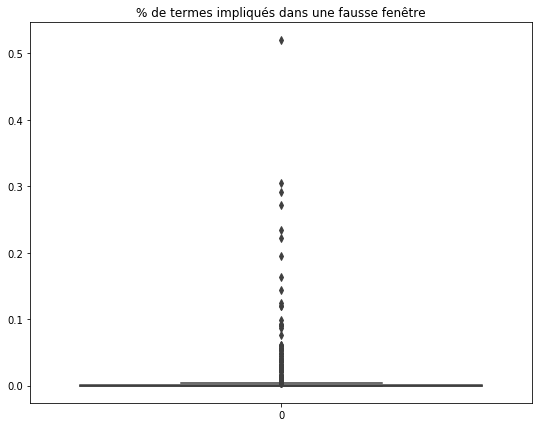

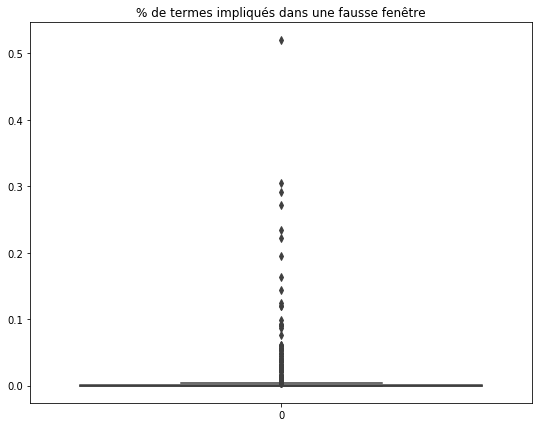

In [5]:
W = 5 # Window

w2vec_windows = DataFrame([
    {
        "id": text_id,
        "mots": sum(passages),
        "passages": len(passages),
        "false_cooccurences": (len(passages) * 2 - 2) * W
    }
    for text_id, passages in available_wordcount_per_edition.items()
])
w2vec_windows["influenced"] = w2vec_windows["false_cooccurences"]/w2vec_windows["mots"]
total_words = w2vec_windows["mots"].sum()
w2vec_windows["corpora_repr"] = w2vec_windows["mots"] / total_words

#print(w2vec_windows[w2vec_windows.influenced > .05]["false_cooccurences"].sum())

display(HTML(w2vec_windows.sort_values(by=['influenced']).to_html()))

fig, ax = pyplot.subplots(figsize =(9, 7)) 
sns.boxplot(
    ax=ax, data=w2vec_windows["influenced"]
).set_title('% de termes impliqués dans une fausse fenêtre')
fig.show()

fig, ax = pyplot.subplots(figsize =(9, 7)) 
sns.boxplot(
    ax=ax, data=w2vec_windows["influenced"]
).set_title('% de termes impliqués dans une fausse fenêtre')
fig.show()

## Taille des passages



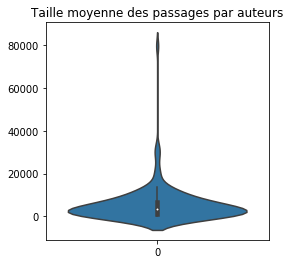

In [6]:
texts = DataFrame([
    {"Auteur": tg, 
     "Passages": psg,
     "Textes": available_textcount[tg],
     "Ratio": psg/available_textcount[tg],
     "Mots": available_wordcount[tg]}
    for tg, psg in available_psgcount.items()
]).set_index("Auteur")

texts["Taille Moyenne"] = texts["Mots"] / texts["Passages"]

fig, ax = pyplot.subplots(figsize =(4, 4)) 
sns.violinplot(ax=ax, data=texts["Taille Moyenne"], 
).set_title('Taille moyenne des passages par auteurs')
fig.show()


Taille                                                56269
Auteur    MartialMartialMartialMartialMartialMartialMart...
dtype: object


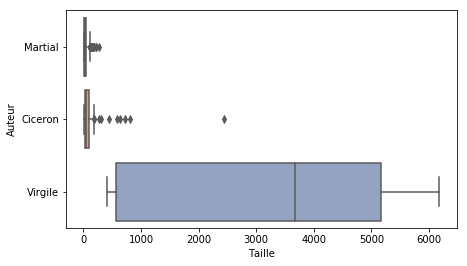

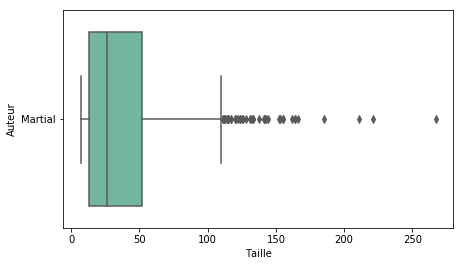

In [8]:
martial = DataFrame(available_wordcount_per_edition["urn:cts:latinLit:phi1294.phi002.perseus-lat2"])
martial["Auteur"] = "Martial"
martial = martial.rename({0: "Taille"}, axis='columns')
virgil = DataFrame([
    occ
    for edition in available_wordcount_per_edition
    if edition.startswith("urn:cts:latinLit:phi0690")
    for occ in available_wordcount_per_edition[edition]
])
virgil["Auteur"] = "Virgile"
virgil = virgil.rename({0: "Taille"}, axis='columns')
cicero = DataFrame([
    occ
    for edition in available_wordcount_per_edition
    if edition.startswith("urn:cts:latinLit:phi0472")
    for occ in available_wordcount_per_edition[edition]
])
cicero["Auteur"] = "Ciceron"
cicero = cicero.rename({0: "Taille"}, axis='columns')

concat = pandas.concat([martial, cicero, virgil])

fig, ax = pyplot.subplots(figsize =(7, 4)) 
ax = sns.boxplot(y="Auteur", x="Taille", data=concat, palette="Set2")
fig.show()

fig, ax = pyplot.subplots(figsize =(7, 4)) 
ax = sns.boxplot(y="Auteur", x="Taille", data=martial, palette="Set2")
fig.show()

print(martial.sum())